In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Input, Conv2D,
    Dropout, BatchNormalization, UpSampling2D,
    concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

In [ ]:
class DataGenerator(object):
    def __init__(self, images_dir, masks_dir,
        batch_size: int = 8, target_size: tuple = (256, 256),
        shuffle: bool = True, seed: int = 8):

        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.seed = seed

        self.imag_datagen = ImageDataGenerator()
        self.mask_datagen = ImageDataGenerator()

    def fit(self):
        self.images_ = self.imag_datagen.flow_from_directory(
            self.images_dir, target_size=self.target_size,
            batch_size=self.batch_size, shuffle=self.shuffle,
            seed=self.seed, class_mode=None, color_mode='grayscale'
        )
        self.masks_ = self.mask_datagen.flow_from_directory(
            self.masks_dir, target_size=self.target_size,
            batch_size=self.batch_size, shuffle=self.shuffle,
            seed=self.seed, class_mode=None, color_mode='grayscale'
        )

        self.STEP_SIZE = self.images_.n // self.batch_size
        self.IMAGES_LIST = self.images_.filenames
        self.MASKS_LIST = self.masks_.filenames
        self.generator = zip(self.images_, self.masks_)

    def generate(self):
        self.images_.reset()
        self.masks_.reset()
        for images, masks in self.generator:
            yield (images / 255., masks / 255.)

In [ ]:
gen = DataGenerator('1_train_image', '2_train_label',
                    batch_size=10, shuffle=True)
gen.fit()
STEP_SIZE = gen.STEP_SIZE

Found 50 images belonging to 1 classes.
Found 50 images belonging to 1 classes.


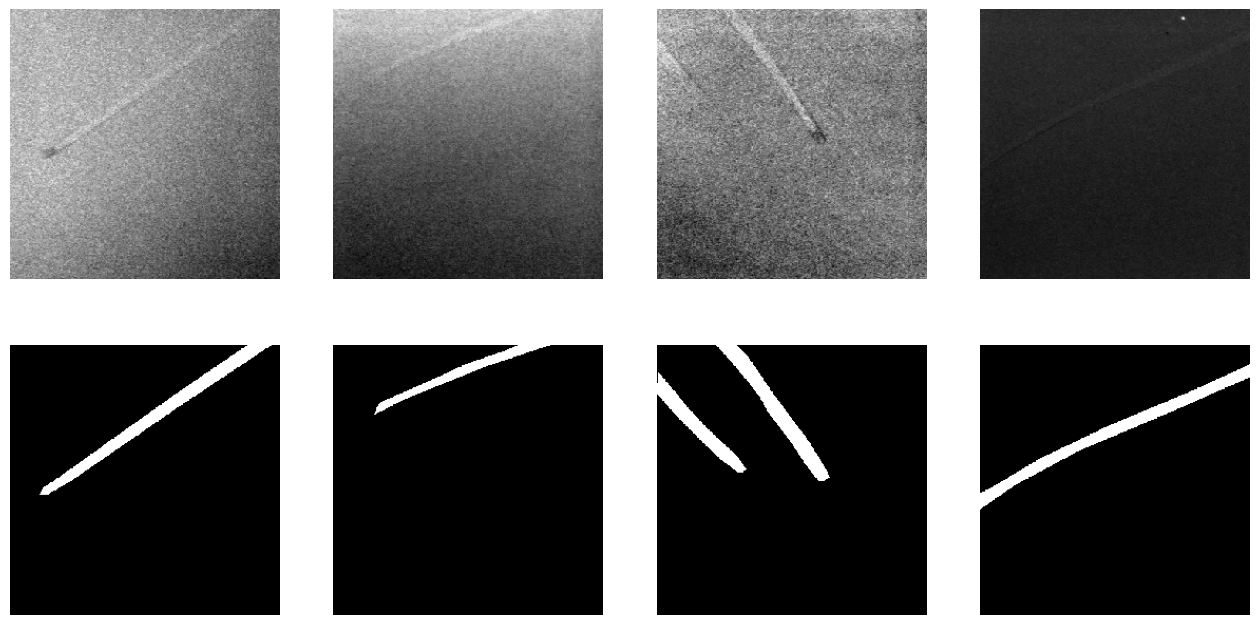

In [ ]:
for image, mask in gen.generate():
  fig, ax = plt.subplots(2, 4, figsize=(16, 8))
  for i in range(len(ax[0])):
    ax[0][i].imshow(image[i, ..., 0], cmap='gray')
    ax[1][i].imshow(mask[i, ..., 0], cmap='gray')
    ax[0][i].set_axis_off()
    ax[1][i].set_axis_off()
  break

In [ ]:
# Conv + ReLU + Dropout + BatchNormalization
def downsample_block(x, filters, dropout=None):
    x = Conv2D(filters, 3, padding='same', activation='relu',
               kernel_initializer='he_normal', strides=2)(x)
    x = Dropout(dropout)(x) if dropout != None else x
    x = BatchNormalization()(x)

    return x

In [ ]:
def upsample_block(x1, x2, filters):
  x1 = UpSampling2D(size=(2, 2))(x1)
  x1 = Conv2D(filters, 3, padding='same', activation='relu',
              kernel_initializer='he_normal')(x1)
  x = concatenate([x2, x1], axis=-1)
  x = Conv2D(filters, 3, padding='same', activation='relu',
             kernel_initializer='he_normal')(x)

  return x

In [ ]:
def build_unet(input_shape=(256, 256, 1), classes=1):
  # Inputs
  inputs = Input(shape=input_shape)

  # Encoder
  f1 = downsample_block(inputs, 32, None)
  f2 = downsample_block(f1, 64, 0.3)

  # Decoder
  u6 = upsample_block(f2, f1, 256)
  u10 = UpSampling2D(size=(2, 2))(u6)
  u10 = Conv2D(32, 3, padding='same', activation='relu',
               kernel_initializer='he_normal')(u10)
  
  # Output
  head = Conv2D(classes, 1, padding='same', activation='sigmoid',
                kernel_initializer='he_normal')(u10)

  unet = Model(inputs, head, name='UNet')

  return unet

In [ ]:
model = build_unet()
#model.summary()

In [ ]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=tf.keras.metrics.BinaryIoU(threshold=0.5))
history = model.fit(gen.generate(), steps_per_epoch=STEP_SIZE, epochs=500)

Epoch 1/500
5/5 [==============================] - 7s 151ms/step - loss: 1.0791 - binary_io_u: 0.4795
Epoch 2/500
5/5 [==============================] - 1s 140ms/step - loss: 0.1937 - binary_io_u: 0.4795
Epoch 3/500
5/5 [==============================] - 1s 138ms/step - loss: 0.1803 - binary_io_u: 0.4795
Epoch 4/500
5/5 [==============================] - 1s 139ms/step - loss: 0.1737 - binary_io_u: 0.4795
Epoch 5/500
5/5 [==============================] - 1s 139ms/step - loss: 0.1719 - binary_io_u: 0.4795
Epoch 6/500
5/5 [==============================] - 1s 138ms/step - loss: 0.1666 - binary_io_u: 0.4795
Epoch 7/500
5/5 [==============================] - 1s 140ms/step - loss: 0.1697 - binary_io_u: 0.4795
Epoch 8/500
5/5 [==============================] - 1s 141ms/step - loss: 0.1681 - binary_io_u: 0.4795
Epoch 9/500
5/5 [==============================] - 1s 140ms/step - loss: 0.1632 - binary_io_u: 0.4795
Epoch 10/500
5/5 [==============================] - 1s 141ms/step - loss: 0.1618 -

In [ ]:
test_gen = DataGenerator('test_images', 'test_labels',
                    batch_size=1, shuffle=True)
test_gen.fit()
TEST_SIZE = test_gen.STEP_SIZE

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


1/1 [==============================] - 0s 19ms/step


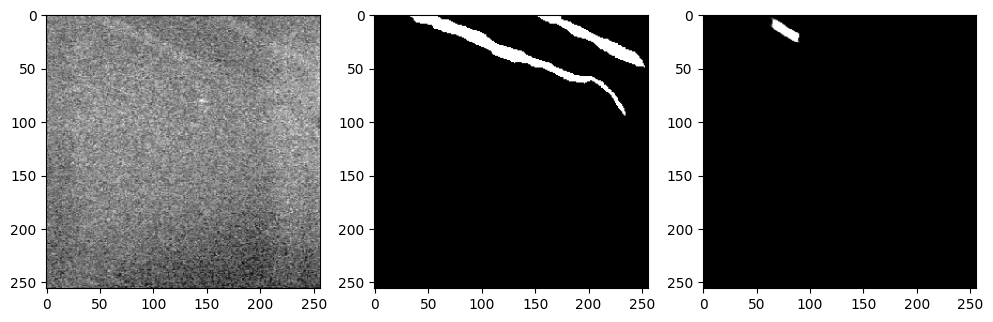

In [ ]:
for image, mask in test_gen.generate():
  fig, ax = plt.subplots(1, 3, figsize=(12, 4))
  ax[0].imshow(image[0, ..., 0], cmap='gray')
  ax[1].imshow(mask[0, ..., 0], cmap='gray')
  out = model.predict(image)
  ax[2].imshow(out[0, ..., 0], cmap='gray')
  break